### Workspace Factory

Make an extended probability density function for a distribution in $m_{\gamma\gamma}$

An extended probability density model is a product of a probability density function $f(x)$ in a continuous observable $x$ and a Poisson model modeling the observed event count $P(N_\mathrm{obs}|N_\mathrm{exp})$

For composite pdfs (a sum of 2 of more components) the conceptual expression 
$$
\mathrm{model}(x,N) = N_\mathrm{sig}*\mathrm{sig}(x) + N_\mathrm{bkg}*\mathrm{bkg}(x)
$$

can be elegantly rewritten in the producy of a  probability density function and Poisson

$$
f_\mathrm{sig} = N_\mathrm{sig} / (N_\mathrm{sig} + N_\mathrm{bkg})
$$
$$
E   = N_\mathrm{sig} + N_\mathrm{bkg}
$$
$$
\mathrm{model}(x) = f_\mathrm{sig} * \mathrm{sig}(x) + (1-f_\mathrm{sig}) * \mathrm{bkg}(x) 
$$
$$
P(N|E)   = \mathrm{Poisson}(N|E)
$$

In [1]:
RooWorkspace w("w") ;


RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt



Exponential distribution for the background and Gaussian distribution for the signal

In [2]:
w.factory("Exponential::bkg(mgg[40,400],alpha[-0.01,-10,0])") ; 
w.factory("Gaussian::sig(mgg,mean[125,80,400],width[3,1,10])") ;

Fix signal shape for now

In [3]:
w.var("mean")->setConstant(true) ;
w.var("width")->setConstant(true) ;

Model is sum of signal and background
$$
S = \mu * S_\mathrm{nom}[200]
$$
$$
B = B_\mathrm{nom}[10000]
$$

In [4]:
w.factory("expr::S('mu*Snom',mu[1,-3,6],Snom[50])") ;
w.factory("SUM::model(S*sig,Bnom[10000]*bkg)") ;

Sample a toy unbinned toy dataset from the model If no event count is given, the predicted count of the model is taken (in this case S+B)

In [5]:
RooDataSet* data = w.pdf("model")->generate(*w.var("mgg")) ;

Fit model to toy data - the extended option forces the inclusion of the Poisson term in the likelihood construction

In [6]:
RooFitResult* r = w.pdf("model")->fitTo(*data,RooFit::Save(),RooFit::Extended()) ;

[#1] INFO:Minization -- createNLL: caching constraint set under name CONSTR_OF_PDF_model_FOR_OBS_mgg with 0 entries
[#1] INFO:Minization -- RooMinimizer::optimizeConst: activating const optimization
[#1] INFO:Minization --  The following expressions have been identified as constant and will be precalculated and cached: (sig)
[#1] INFO:Minization --  The following expressions will be evaluated in cache-and-track mode: (bkg)
 **********
 **    1 **SET PRINT           1
 **********
 **********
 **    2 **SET NOGRAD
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 alpha       -1.00000e-02  5.00000e-03   -1.00000e+01  0.00000e+00
     2 mu           1.00000e+00  9.00000e-01   -3.00000e+00  6.00000e+00
 **********
 **    3 **SET ERR         0.5
 **********
 **********
 **    4 **SET PRINT           1
 **********
 **********
 **    5 **SET STR           1
 **********
 NOW USING STRATEGY  1: TRY TO BALANCE SPEED AGAINST RELIABILITY
 **********


Visualize result

In [7]:
TCanvas* c1 = new TCanvas();
RooPlot* frame = w.var("mgg")->frame() ;
data->plotOn(frame) ;

When plotting an extended pdf you can choose to follow intrinsic prediction for the event count, rather than normalizing the plot to the observed data

To do so request a normalization scale factor 1.0 w.r.t the intrinsic expecation

In [8]:
w.pdf("model")->plotOn(frame,RooFit::Normalization(1.0,RooAbsReal::RelativeExpected)) ;

You can also highlight components of the fit as follows

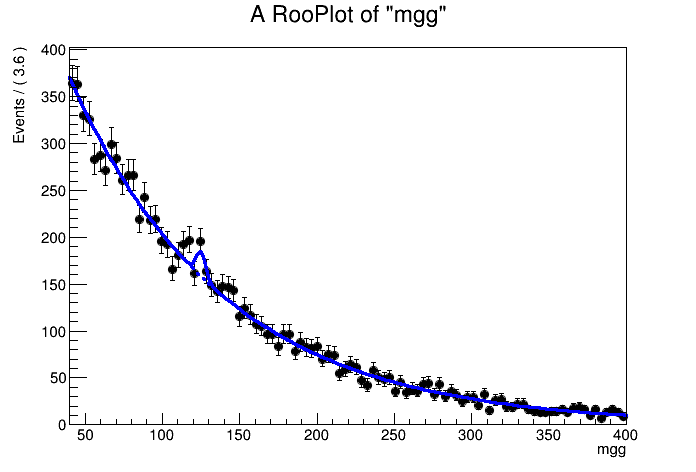

[#1] INFO:Plotting -- RooAbsPdf::plotOn(model) directly selected PDF components: (bkg)
[#1] INFO:Plotting -- RooAbsPdf::plotOn(model) indirectly selected PDF components: ()


In [9]:
w.pdf("model")->plotOn(frame,RooFit::Normalization(1.0,RooAbsReal::RelativeExpected),RooFit::Components("bkg"),RooFit::LineStyle(kDashed)) ;
frame->Draw() ;
c1->Draw() ;

Now save the workspace with the data a modelconfig so that you can use RooStats to extract limits

Save the generated data as the 'observed data'

In [10]:
w.import(*data,RooFit::Rename("observed_data")) ;

[#1] INFO:ObjectHandling -- RooWorkspace::import(w) importing dataset modelData
[#1] INFO:ObjectHandling -- RooWorkSpace::import(w) changing name of dataset from  modelData to observed_data


Create an empty ModelConfig

In [11]:
RooStats::ModelConfig mc("ModelConfig",&w);

Define the pdf, the parameter of interest and the observables

In [12]:
mc.SetPdf(*w.pdf("model"));
mc.SetParametersOfInterest(*w.var("mu"));
//mc.SetNuisanceParameters(RooArgSet(*w.var("mean"),*w.var("width"),*w.var("alpha")));
mc.SetNuisanceParameters(*w.var("alpha"));
mc.SetObservables(*w.var("mgg"));

Define the current value mu (1) as an hypothesis

In [13]:
w.var("mu")->setVal(1) ;
mc.SetSnapshot(*w.var("mu"));

mc.Print();


=== Using the following for ModelConfig ===
Observables:             RooArgSet:: = (mgg)
Parameters of Interest:  RooArgSet:: = (mu)
Nuisance Parameters:     RooArgSet:: = (alpha)
PDF:                     RooAddPdf::model[ S * sig + Bnom * bkg ] = 0.110271
Snapshot:                
  1) 0x7f1a20b9fa80 RooRealVar:: mu = 1 +/- 0.459294  L(-3 - 6)  "mu"



import model into the workspace and save to file

In [14]:
w.import(mc);

w.writeToFile("model.root") ;